# Import

In [17]:
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns 
from sklearn.linear_model import LogisticRegression


In [18]:
df = pd.read_csv('flats.csv')

# EDA

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6042 entries, 0 to 6041
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  6042 non-null   int64  
 1   price_doc   6042 non-null   int64  
 2   full_sq     6042 non-null   int64  
 3   life_sq     6042 non-null   float64
 4   num_room    6042 non-null   float64
 5   kitch_sq    6042 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 283.3 KB


In [20]:
df

,Unnamed: 0,price_doc,full_sq,life_sq,num_room,kitch_sq
0,8056,2750000,11,11.0,1.0,12.0
1,8154,7100000,45,27.0,2.0,6.0
2,8287,11700000,77,50.0,3.0,8.0
3,8387,10400000,56,29.0,2.0,10.0
4,8391,6200000,31,21.0,1.0,5.0
...,...,...,...,...,...,...
6037,30462,10544070,47,30.0,1.0,10.0
6038,30463,12000000,56,29.0,2.0,11.0
6039,30467,25000000,86,59.0,4.0,10.0
6040,30469,13500000,64,32.0,2.0,11.0


In [21]:
df['#'] = df['Unnamed: 0']
df.drop('Unnamed: 0', axis=1, inplace=True)

In [22]:
df

,price_doc,full_sq,life_sq,num_room,kitch_sq,#
0,2750000,11,11.0,1.0,12.0,8056
1,7100000,45,27.0,2.0,6.0,8154
2,11700000,77,50.0,3.0,8.0,8287
3,10400000,56,29.0,2.0,10.0,8387
4,6200000,31,21.0,1.0,5.0,8391
...,...,...,...,...,...,...
6037,10544070,47,30.0,1.0,10.0,30462
6038,12000000,56,29.0,2.0,11.0,30463
6039,25000000,86,59.0,4.0,10.0,30467
6040,13500000,64,32.0,2.0,11.0,30469


In [48]:
df.describe()

,price_doc,life_sq,num_room,kitch_sq,#
count,6.042000e+03,6042.000000,6042.000000,6042.000000,6042.000000
mean,8.750423e+06,33.198941,1.997021,7.391096,19846.990070
std,6.277290e+06,20.190005,0.889523,3.806198,6081.011373
min,5.000000e+05,0.000000,0.000000,0.000000,8056.000000
25%,5.800000e+06,20.000000,1.000000,5.000000,14573.250000
50%,7.400000e+06,29.000000,2.000000,7.000000,19871.500000
75%,1.050000e+07,42.000000,3.000000,9.000000,25147.750000
max,9.512250e+07,637.000000,17.000000,96.000000,30470.000000


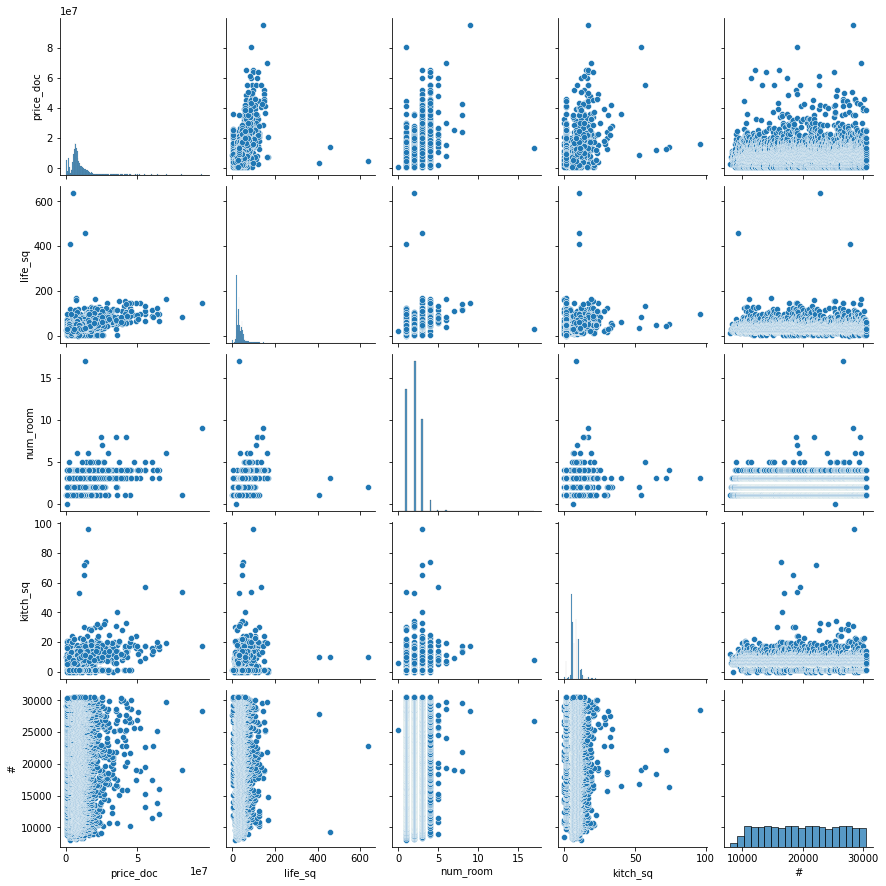

In [32]:
numeric_features = df.select_dtypes(include="number").columns
sns.pairplot(df[numeric_features])

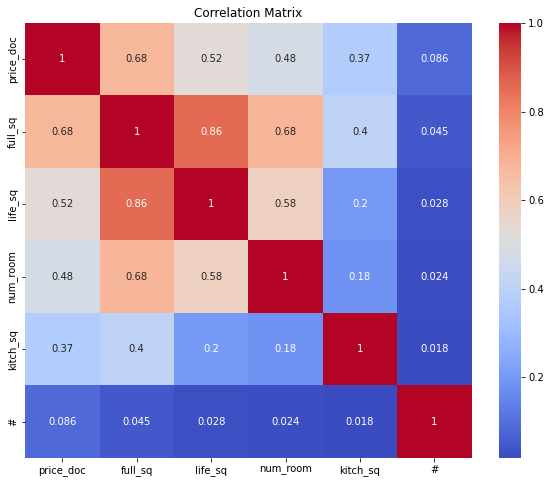

In [24]:
# Вычислим матрицу корреляции
corr_matrix = df.corr()

#  тепловая карта матрицы корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Добавив название графика
plt.title('Correlation Matrix')

# Отобразим график
plt.show()

In [25]:
df.drop('full_sq', axis=1, inplace=True)

In [26]:
# Проверим дубликаты
duplicates = df.duplicated()
print('Всего дубликатов: {}'.format(duplicates.sum()))

Всего дубликатов: 0


In [27]:
# Проверка пропусков во всем датасете
missing_values = df.isnull().sum().sum()
print('Всего пропусков: {}'.format(missing_values))

Всего пропусков: 0


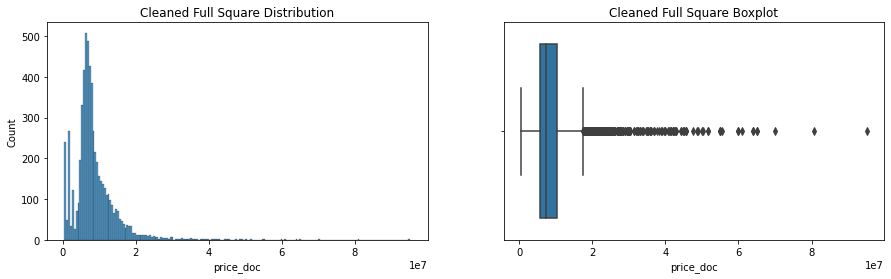

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='price_doc', ax=axes[0]);
histplot.set_title('Cleaned Full Square Distribution');
boxplot = sns.boxplot(data=df, x='price_doc', ax=axes[1]);
boxplot.set_title('Cleaned Full Square Boxplot');

In [41]:
def find_outliers_iqr(data, feature, left=1.5, right=1.5, log_scale=False):
    """
    Находит выбросы в данных, используя метод межквартильного размаха. 
    Классический метод модифицирован путем добавления:
    * возможности логарифмирования распредления
    * ручного управления количеством межквартильных размахов в обе стороны распределения
    Args:
        data (pandas.DataFrame): набор данных
        feature (str): имя признака, на основе которого происходит поиск выбросов
        left (float, optional): количество межквартильных размахов в левую сторону распределения. По умолчанию 1.5.
        right (float, optional): количество межквартильных размахов в правую сторону распределения. По умолчанию 1.5.
        log_scale (bool, optional): режим логарифмирования. По умолчанию False - логарифмирование не применяется.

    Returns:
        pandas.DataFrame: наблюдения, попавшие в разряд выбросов
        pandas.DataFrame: очищенные данные, из которых исключены выбросы
    """
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x= data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned

def outliers_z_score(data, feature, left=3, right=3, bias=1, log_scale=False):
    """Функция получает на вход числовые данные, проводит оценку на наличие выбросов методом z-отклонений и возвращает 
    исключенные данные и очищенные данные

    Args:
        data ([pd.DataFrame]): Входные данные в формате pd.DataFrame
        feature ([int, float]): Числовой признак, который подвергается анализу и чистке
        log_scale (bool, optional): Булевый аргумент для использования логарифмического масштаба, Defaults to False.
        left (int, optional): Поправочный коэффициент - соответствует количеству стандартных квадратичных отклонений влево
        right (int, optional): Поправочный коэффициент - соответствует количеству стандартных квадратичных отклонений вправо
        bias (int, optional): Cмещение по оси х для логарифмического масштаба, в случае наличия нулевых значений в данных

    Returns:
        [pd.DataFrame]: Возвращает два pd.DataFrame с исключенными данными outliers и очищенными данными data_cleaned
    """
    
    # Проверка включения логарифмического масштаба
    if log_scale:
        x = np.log(data[feature]+bias)
    else:
        x = data[feature]
    
    # Вычисление статистических величин
    mu = x.mean() #мат. ожидание
    sigma = x.std() #стандартное отклонение
    
    lower_bound = mu - left * sigma # Определение нижней границы распределения
    upper_bound = mu + right * sigma # Определение верхней границы распределения
    
    # очистка данных
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    
    return outliers, cleaned

In [42]:
outliers, cleaned = outliers_z_score(df, 'price_doc', 3, 4, bias=0, log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 1
Результирующее число записей: 6041


In [43]:
outliers, cleaned = find_outliers_iqr(df, 'price_doc', left=2, right=2, log_scale=True)
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 356
Результирующее число записей: 5686


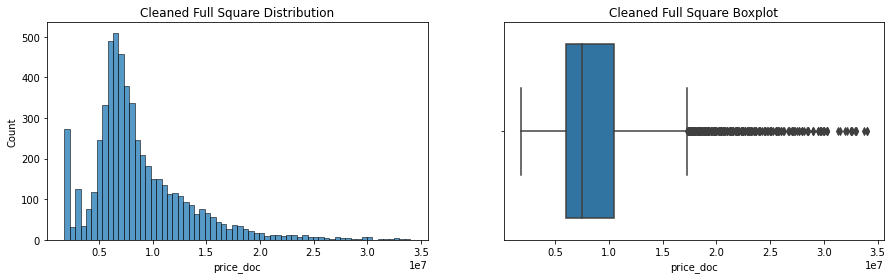

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='price_doc', ax=axes[0]);
histplot.set_title('Cleaned Full Square Distribution');
boxplot = sns.boxplot(data=cleaned, x='price_doc', ax=axes[1]);
boxplot.set_title('Cleaned Full Square Boxplot');

Text(0.5, 1.0, 'Распределение признака "price_doc" в логарифмическом масштабе')

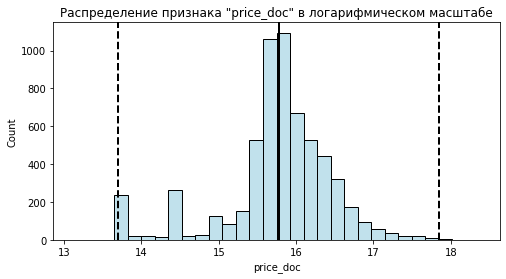

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_age = np.log(df['price_doc'])
histplot = sns.histplot(log_age, bins=30, color= 'lightblue', ax=ax)
histplot.axvline(log_age.mean(), color='k', lw=2)
histplot.axvline(log_age.mean()+ 3 * log_age.std(), color='k', ls='--', lw=2)
histplot.axvline(log_age.mean()- 3 * log_age.std(), color='k', ls='--', lw=2)
histplot.set_title('Распределение признака "price_doc" в логарифмическом масштабе')

In [52]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('price_doc ~ life_sq + num_room + kitch_sq', df)
    trace = pm.sample(1000)
    
az.plot_trace(trace);

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
c:\Users\askar\AppData\Local\Programs\Python\Python39\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\Users\askar\AppData\Local\Programs\Python\Python39\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\Users\askar\AppData\Local\Programs\Python\Python39\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Sequential sampling (2 chain

c:\Users\askar\AppData\Local\Programs\Python\Python39\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: overflow encountered in exp
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\Users\askar\AppData\Local\Programs\Python\Python39\lib\site-packages\theano\scalar\basic.py:2893: RuntimeWarning: divide by zero encountered in log
  return np.log(x)
c:\Users\askar\AppData\Local\Programs\Python\Python39\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\Users\askar\AppData\Local\Programs\Python\Python39\lib\site-packages\theano\scalar\basic.py:1955: RuntimeWarning: invalid value encountered in true_divide
  return x / y
c:\Users\askar\AppData\Local\Programs\Python\Python39\lib\site-packages\theano\scalar\basic.py:3167: RuntimeWarning: overflow encountered in double_scalars
  return x * x
c:\Users\askar\AppData\Local\Programs\Python\Python39\lib\site-packages\th

ValueError: Can not extract posterior from <MultiTrace: 1 chains, 0 iterations, 6 variables>! See c:\Users\askar\AppData\Local\Programs\Python\Python39\lib\site-packages\arviz\data\converters.py for other conversion utilities.